In [128]:
import numpy as np
import scipy.io as si
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy
from netCDF4 import Dataset
import pickle
import datetime
from scipy.optimize import fmin
from scipy.signal import savgol_filter
# functions I've written
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

In [440]:
# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 36
ref_lon = 64.2

# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 40
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 4000  # 3900

In [441]:
# ----------------------------------------------------------------------------------------------------------------------
# ---- PROCESSING USING GLIDER PACKAGE
gs = 52
ge = 165
x = Glider(41, np.arange(gs, ge), '/Users/jake/Documents/baroclinic_modes/DG/BATS_2018/sg041')
# ----------------------------------------------------------------------------------------------------------------------
import_dg = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg041_2018_neutral_density_bin.mat')
dg_data = import_dg['out']
limm = 471
profile_tags = dg_data['prof_number'][0][0][0]
if profile_tags[0] == gs:
    first = 0
else:
    first = np.where(profile_tags < gs)[0][-1] + 1
if profile_tags[-1] == ge - 0.5:
    last = len(profile_tags)
else:
    last = np.where(profile_tags > ge)[0][0] - 1
d_in = range(first, last)
profile_tags = profile_tags[d_in]
neutral_density = dg_data['Neut_den'][0][0][0:limm, d_in]
t = dg_data['Temp'][0][0][0:limm, d_in]
s = dg_data['Sal'][0][0][0:limm, d_in]
lon = dg_data['Lon'][0][0][0:limm, d_in]
lat = dg_data['Lat'][0][0][0:limm, d_in]
dac_u = dg_data['Dac_u'][0][0][0][d_in]
dac_v = dg_data['Dac_v'][0][0][0][d_in]
d_time = dg_data['Time'][0][0][0:limm, d_in] - 366
ref_lat = np.nanmean(lat)
time_rec_bin = np.nanmean(d_time, axis=0)

grid = dg_data['Depth'][0][0][0:limm, 0]
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
z = -1 * grid
sz_g = grid.shape[0]
# ----------------------------------------------------------------------------------------------------------------------
# -- Compute density
sa, ct, theta, sig0, sig2, dg_N2 = x.density(grid, ref_lat, t, s, lon, lat)

In [442]:
datetime.date.fromordinal(737149)

datetime.date(2019, 3, 31)

In [445]:
# N2 (seasonal split )
t_s = datetime.date.fromordinal(np.int(np.nanmin(d_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(d_time)))

# --- Two seasons
# - earliest date is ~ Oct 1 (736968), define winter as Nov 15 (737013) - Mar 31 (737149) 

bd1 = 737013
bd2 = 737149

d_fall = np.where((time_rec_bin < bd1) & ((profile_tags < 55) | (profile_tags > 66)))[0]
d_win = np.where((time_rec_bin > bd1) & (time_rec_bin < bd2))[0]
d_ring = np.where((profile_tags > 53) & (profile_tags < 66))[0]

bckgrds = [d_fall, d_win, d_ring]
bckgrds_info = ['Fall', 'Winter', 'Ring']

salin_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
cons_t_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
sigma_theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
ddz_avg_sigma = np.nan * np.zeros((len(grid), len(bckgrds)))
N2_0 = np.nan * np.zeros(sigma_theta_avg.shape)
N2_ref = np.nan * np.zeros(sigma_theta_avg.shape)
N = np.nan * np.zeros(sigma_theta_avg.shape)
for i in range(len(bckgrds)):
    inn = bckgrds[i]
    salin_avg[:, i] = np.nanmean(sa[:, inn], axis=1)
    cons_t_avg[:, i] = np.nanmean(ct[:, inn], axis=1)
    theta_avg[:, i] = np.nanmean(theta[:, inn], axis=1)
    sigma_theta_avg[:, i] = np.nanmean(neutral_density[:, inn], axis=1)
    ddz_avg_sigma[:, i] = np.gradient(sigma_theta_avg[:, i], z)
    go = ~np.isnan(salin_avg[:, i])
    N2_0[np.where(go)[0][0:-1], i] = gsw.Nsquared(salin_avg[go, i], cons_t_avg[go, i], grid_p[go], lat=ref_lat)[0]
    N2_0[N2_0[:, i] < 0] = np.nan  # 1 * 10**-7
    N2_ref[:, i] = nanseg_interp(grid, N2_0[:, i])
    # N2_ref[:, i] = savgol_filter(N2_ref[:, i], 5, 3)
N2_ref[-1, :] = N2_ref[-2, :] - 1 * 10**-9
N2 = N2_ref.copy()

N2_all = np.nan * np.zeros(len(grid))
N2_all[0:-1] = gsw.Nsquared(np.nanmean(salin_avg, axis=1), np.nanmean(cons_t_avg, axis=1), grid_p, lat=ref_lat)[0]
N2_all[-2:] = N2_all[-3]
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)
N_all = np.sqrt(N2_all)
N2_all = savgol_filter(N2_all, 5, 3)
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)

[ 52.   52.5  53.   53.5  54.   54.5  66.5  67.   67.5  68.   68.5  69.
  69.5  70.   70.5  71.   71.5  72.   72.5  73. ]


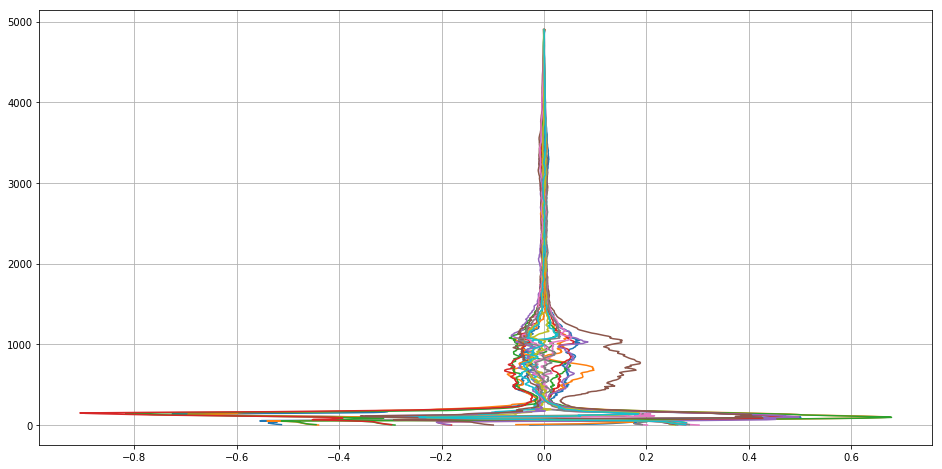

()

In [446]:
print(profile_tags[d_fall])
# f, ax = plt.subplots()
# for i in range(len(d_fall)):
#     ax.plot(neutral_density[:, d_fall[i]] - sigma_theta_avg[:, 0], grid)
# plot_pro(ax)    

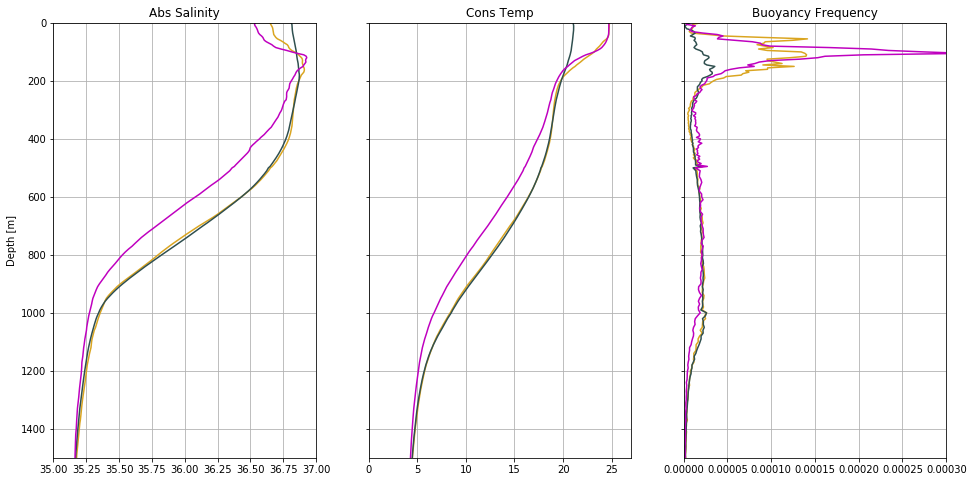

()

In [447]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
coli = '#DAA520','#2F4F4F', 'm', '#2F4F4F', '#DAA520', '#DAA520'
for i in range(len(bckgrds)):
    ax1.plot(salin_avg[:, i], grid, color=coli[i])
    ax2.plot(cons_t_avg[:, i], grid, color=coli[i])
    ax3.plot(N2_ref[:, i], grid, color=coli[i])
ax1.set_ylim([0, 1500])
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
ax1.set_xlim([35, 37])
ax1.set_ylabel('Depth [m]')
ax1.set_title('Abs Salinity')
ax2.set_xlim([0, 27])
ax2.set_title('Cons Temp')
ax3.set_xlim([0, 0.0003])
ax3.set_title('Buoyancy Frequency')
plot_pro(ax3)

In [448]:
# -------------------------------------------------------------------------------------------------
# -- compute M/W sections and compute velocity
# -- USING X.TRANSECT_CROSS_SECTION_1 (THIS WILL SEPARATE TRANSECTS BY TARGET OF EACH DIVE)
sigth_levels = np.concatenate(
    [np.arange(23, 26.5, 0.5), np.arange(26.2, 27.2, 0.2),
     np.arange(27.2, 27.7, 0.2), np.arange(27.7, 28, 0.02), np.arange(28, 28.15, 0.01)])
# sigth_levels = np.concatenate([np.aranger(32, 36.6, 0.2), np.arange(36.6, 36.8, 0.05), np.arange(36.8, 37.4, 0.02)])

# --- SAVE so that we don't have to run transects every time
savee = 0
if savee > 0:
    ds, dist, avg_ct_per_dep_0, avg_sa_per_dep_0, avg_sig0_per_dep_0, v_g, vbt, isopycdep, isopycx, mwe_lon, mwe_lat,\
    DACe_MW, DACn_MW, profile_tags_per, shear, v_g_east, v_g_north = x.transect_cross_section_1(grid, neutral_density,
                                                                                                ct, sa, lon, lat,
                                                                                                dac_u, dac_v,
                                                                                                profile_tags,
                                                                                                sigth_levels)
    my_dict = {'ds': ds, 'dist': dist, 'avg_ct_per_dep_0': avg_ct_per_dep_0,
               'avg_sa_per_dep_0': avg_sa_per_dep_0, 'avg_sig0_per_dep_0': avg_sig0_per_dep_0, 'v_g': v_g, 'vbt': vbt,
               'isopycdep': isopycdep, 'isopycx': isopycx, 'mwe_lon': mwe_lon, 'mwe_lat': mwe_lat, 'DACe_MW': DACe_MW,
               'DACn_MW': DACn_MW, 'profile_tags_per': profile_tags_per, 'v_g_east': v_g_east, 'v_g_north': v_g_north}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg041_2018_transects_gamma.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()
else:
    pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg041_2018_transects_gamma.pkl', 'rb')
    B15 = pickle.load(pkl_file)
    pkl_file.close()
    ds = B15['ds']
    dist = B15['dist']
    avg_ct_per_dep_0 = B15['avg_ct_per_dep_0']
    avg_sa_per_dep_0 = B15['avg_sa_per_dep_0']
    avg_sig0_per_dep_0 = B15['avg_sig0_per_dep_0']
    v_g = B15['v_g']
    v_g_east = B15['v_g_east']
    v_g_north = B15['v_g_north']
    vbt = B15['vbt']
    isopycdep = B15['isopycdep']
    isopycx = B15['isopycx']
    mwe_lon = B15['mwe_lon']
    mwe_lat = B15['mwe_lat']
    DACe_MW = B15['DACe_MW']
    DACn_MW = B15['DACn_MW']
    profile_tags_per = B15['profile_tags_per']

# unpack velocity profiles from transect analysis
dace_mw_0 = DACe_MW[0][0:-1].copy()
dacn_mw_0 = DACn_MW[0][0:-1].copy()
dg_v_0 = v_g[0][:, 0:-1].copy()
dg_v_e_0 = v_g_east[0][:, 0:-1].copy()
dg_v_n_0 = v_g_north[0][:, 0:-1].copy()
avg_sig0_per_dep = avg_sig0_per_dep_0[0].copy()
avg_ct_per_dep = avg_ct_per_dep_0[0].copy()
avg_sa_per_dep = avg_sa_per_dep_0[0].copy()
dg_v_lon_0 = mwe_lon[0][0:-1].copy()
dg_v_lat_0 = mwe_lat[0][0:-1].copy()
dg_v_dive_no_0 = profile_tags_per[0][0:-1].copy()
for i in range(1, len(v_g)):
    dace_mw_0 = np.concatenate((dace_mw_0, DACe_MW[i][0:-1]), axis=0)
    dacn_mw_0 = np.concatenate((dacn_mw_0, DACn_MW[i][0:-1]), axis=0)
    dg_v_0 = np.concatenate((dg_v_0, v_g[i][:, 0:-1]), axis=1)
    dg_v_e_0 = np.concatenate((dg_v_e_0, v_g_east[i][:, 0:-1]), axis=1)
    dg_v_n_0 = np.concatenate((dg_v_n_0, v_g_north[i][:, 0:-1]), axis=1)
    avg_ct_per_dep = np.concatenate((avg_ct_per_dep, avg_ct_per_dep_0[i]), axis=1)
    avg_sa_per_dep = np.concatenate((avg_sa_per_dep, avg_sa_per_dep_0[i]), axis=1)
    avg_sig0_per_dep = np.concatenate((avg_sig0_per_dep, avg_sig0_per_dep_0[i]), axis=1)
    dg_v_lon_0 = np.concatenate((dg_v_lon_0, mwe_lon[i][0:-1]))
    dg_v_lat_0 = np.concatenate((dg_v_lat_0, mwe_lat[i][0:-1]))
    dg_v_dive_no_0 = np.concatenate((dg_v_dive_no_0, profile_tags_per[i][0:-1]))

# Time matching to eta/v profiles
count = 0
for i in range(0, len(profile_tags_per)):
    these_dives = profile_tags_per[i]
    for j in range(len(these_dives) - 1):
        tin = time_rec_bin[np.in1d(profile_tags, these_dives[j:j+2])]
        if count < 1:
            dg_mw_time_0 = np.array([np.nanmean(tin)])
        else:
            dg_mw_time_0 = np.concatenate((dg_mw_time_0, np.array([np.nanmean(tin)])))
        count = count + 1

prof_lon_i = np.nanmean(lon, axis=0)
prof_lat_i = np.nanmean(lat, axis=0)         

transects = [[19, 20], [34, 35, 36], [47, 48], [64, 65], [82, 83], [93, 94], [104, 105]]
[19, 20]
index_start = 38
index_end = 42
dive cycles in this transect = [ 71.   71.5  72.   72.5]

/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:616: RuntimeWarning: Mean of empty slice
  info[1, i] = np.nanmean(lon_pa_M)
/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:617: RuntimeWarning: Mean of empty slice
  info[2, i] = np.nanmean(lat_pa_M)



profile # = [ 71.   71.5  72. ]
[34, 35, 36]
index_start = 68
index_end = 74
dive cycles in this transect = [ 86.   86.5  87.   87.5  88.   88.5]
profile # = [ 86.   86.5  87.   87.5  88. ]
[47, 48]
index_start = 94
index_end = 98
dive cycles in this transect = [  99.    99.5  100.   100.5]
profile # = [  99.    99.5  100. ]
[64, 65]
index_start = 128
index_end = 132
dive cycles in this transect = [ 116.   116.5  117.   117.5]
profile # = [ 116.   116.5  117. ]
[82, 83]
index_start = 164
index_end = 168
dive cycles in this transect = [ 134.   134.5  135.   135.5]


/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:559: RuntimeWarning: Mean of empty slice
  sigma_theta_pa_W[j] = np.nanmean(sigmathetaW)  # average density across 4 profiles


profile # = [ 134.   134.5  135. ]
[93, 94]
index_start = 186
index_end = 190
dive cycles in this transect = [ 145.   145.5  146.   146.5]
profile # = [ 145.   145.5  146. ]
[104, 105]
index_start = 208
index_end = 212
dive cycles in this transect = [ 156.   156.5  157.   157.5]
profile # = [ 156.   156.5  157. ]
transects = [[17, 18], [31, 32, 33], [44, 45, 46], [58, 59, 60, 61, 62, 63], [79, 80, 81], [91, 92], [102, 103]]
[17, 18]
index_start = 34
index_end = 38
dive cycles in this transect = [ 69.   69.5  70.   70.5]
profile # = [ 69.   69.5  70. ]
[31, 32, 33]
index_start = 62
index_end = 68
dive cycles in this transect = [ 83.   83.5  84.   84.5  85.   85.5]
profile # = [ 83.   83.5  84.   84.5  85. ]
[44, 45, 46]
index_start = 88
index_end = 94
dive cycles in this transect = [ 96.   96.5  97.   97.5  98.   98.5]
profile # = [ 96.   96.5  97.   97.5  98. ]
[58, 59, 60, 61, 62, 63]
index_start = 116
index_end = 128
dive cycles in this transect = [ 110.   110.5  111.   111.5  112.  

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


profile # = [ 92.   92.5  93.   93.5  94. ]
[54, 55]
index_start = 108
index_end = 112
dive cycles in this transect = [ 106.   106.5  107.   107.5]
profile # = [ 106.   106.5  107. ]
[73, 74]
index_start = 146
index_end = 150
dive cycles in this transect = [ 125.   125.5  126.   126.5]
profile # = [ 125.   125.5  126. ]
[88, 89]
index_start = 176
index_end = 180
dive cycles in this transect = [ 140.   140.5  141.   141.5]
profile # = [ 140.   140.5  141. ]
[99, 100]
index_start = 198
index_end = 202
dive cycles in this transect = [ 151.   151.5  152.   152.5]
profile # = [ 151.   151.5  152. ]
[111, 112]
index_start = 222
index_end = 226
dive cycles in this transect = [ 163.   163.5  164.   164.5]
profile # = [ 163.   163.5  164. ]
transects = [[2, 3], [22, 23, 24], [38, 39], [51, 52, 53], [69, 70, 71, 72], [85, 86, 87], [96, 97, 98], [107, 108, 109, 110]]
[2, 3]
index_start = 4
index_end = 8
dive cycles in this transect = [ 54.   54.5  55.   55.5]
profile # = [ 54.   54.5  55. ]
[22, 

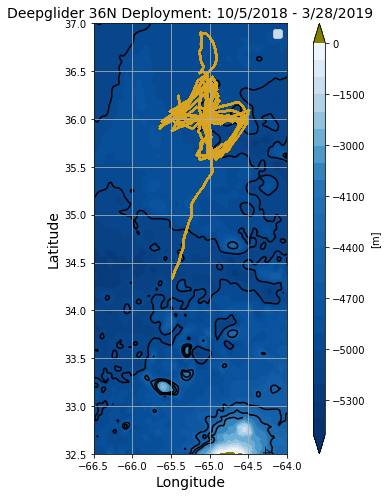

()

In [260]:
# PLAN VIEW PLOt
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.rcParams['figure.figsize'] = (7,7)


bath = '/Users/jake/Desktop/bats/bats_bathymetry/GEBCO_2014_2D_-67.7_29.8_-59.9_34.8.nc'
bath = '/Users/jake/Desktop/bats/bats_bathymetry/bathymetry_b38e_27c7_f8c3_f3d6_790d_30c7.nc'
bath_fid = Dataset(bath, 'r')
bath_lon = bath_fid.variables['longitude'][:]
bath_lat = bath_fid.variables['latitude'][:]
bath_z = bath_fid.variables['z'][:]
levels = [-5500, -5400, -5300, -5200, -5100, -5000, -4900, -4800, -4700, -4600,
          -4500, -4400, -4300, -4200, -4100, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0]
fig0, ax0 = plt.subplots()
cmap = plt.cm.get_cmap("Blues_r")
cmap.set_over('#808000')  # ('#E6E6E6')
bc = ax0.contourf(bath_lon, bath_lat, bath_z, levels, cmap='Blues_r', extend='both', zorder=0)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
bcl = ax0.contour(bath_lon, bath_lat, bath_z, [-5500, -5000, -4500, -4250, -4000], colors='k', zorder=0)
ml = [(-65, 31.5), (-64.4, 32.435)]
ax0.clabel(bcl, manual=ml, inline_spacing=-3, fmt='%1.0f', colors='k')

ax0.scatter(lon, lat, s=0.2, color='#DAA520')
# ax0.scatter(dg_v_lon, dg_v_lat, s=3, color='#DAA520', edgecolor='#B8860B')
# ax0.plot(lon[:, -1], lat[:, -1], color='#DAA520',
#         label='Dive-cyle No. (' + str(int(profile_tags[0])) + '-' + str(int(profile_tags[-2])) + ')', zorder=1)

ax0.scatter(-(64 + (10 / 60)), 31 + (40 / 60), s=50, color='#E6E6FA', edgecolors='k', zorder=3)
ax0.scatter(-(64 + (10 / 60)), 31 + (40 / 60), s=50, color='#E6E6FA', edgecolors='k', zorder=4)
w = 1 / np.cos(np.deg2rad(ref_lat))
ax0.axis([-66.5, -64, 32.5, 37])
ax0.set_aspect(w)
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig0.colorbar(bc, cax=cax, label='[m]')
ax0.set_xlabel('Longitude', fontsize=14)
ax0.set_ylabel('Latitude', fontsize=14)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=11)
ax0.set_title('Deepglider 36N Deployment: ' + np.str(t_s.month) + '/' + np.str(t_s.day) + '/' + np.str(
    t_s.year) + ' - ' + np.str(t_e.month) + '/' + np.str(t_e.day) + '/' + np.str(t_e.year), fontsize=14)
plt.tight_layout()
plot_pro(ax0)
# fig0.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/36b_plan.jpg", dpi=300)

In [55]:
np.nanmax(bath_lon)

-60.0

(1201,)
(1201,)
(1201, 1201)
36.0


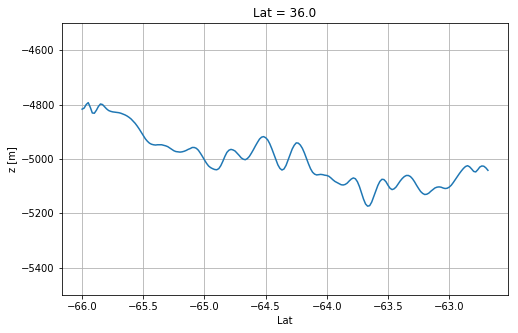

In [72]:
print(np.shape(bath_lon))
print(np.shape(bath_lat))
print(np.shape(bath_z))
lat_sel = 660
lon_sel = np.arange(840, 1040)
print(bath_lat[lat_sel])

lon_in = bath_lon[lon_sel]
z_sel = bath_z[lat_sel, lon_sel]
x_in = 1852 * 60 * np.cos(np.deg2rad(36.00)) * (lon_in - lon_in[0])

# print(np.polyfit(x_sel, z_sel, 1))
fitt = np.polyval(np.polyfit(x_in, z_sel, 1), np.arange(0, 150000, 10000))

matplotlib.rcParams['figure.figsize'] = (8,5)
f, ax  = plt.subplots()
ax.plot(lon_in, z_sel)
# ax.plot(np.arange(0, 150000, 10000), fitt)
ax.set_title('Lat = ' + str(bath_lat[lat_sel]))
ax.set_ylabel('z [m]')
ax.set_xlabel('Lat')
ax.set_ylim([-5500, -4500])
plot_pro(ax)
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/36n_bathy.jpg", dpi=300)

In [284]:
eta_fit_depth_max

4000

In [449]:
# ----------------------------------------------------------------------------------------------------------------------
# ----- Eta compute from M/W method, which produces an average density per set of profiles
eta_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_2 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_3 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
d_anom_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
gradient_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
for i in range(np.shape(avg_sig0_per_dep)[1]):  # loop over each profile
    # (average of four profiles) - (total long term average, that is seasonal)
    this_time = dg_mw_time_0[i]
    avg_a_salin = salin_avg
    avg_c_temp = cons_t_avg
    
    if (this_time < bd1):  # fall
        t_over = 0  
    elif (this_time > bd1) & (this_time < bd2):  # winter 
        t_over = 1  

    this_sigma_theta_avg = sigma_theta_avg[:, t_over]
    eta_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
    d_anom_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over])        
        
    # loop over each bin depth
    avg_a_salin = salin_avg[:, t_over]
    avg_c_temp = cons_t_avg[:, t_over]
    for j in range(1, len(grid) - 1):
        # profile density at depth j with local
        this_sigma = gsw.rho(avg_sa_per_dep[j, i], avg_ct_per_dep[j, i], grid_p[j]) - 1000      # profile density
        # background density with local reference pressure
        this_sigma_avg = gsw.rho(avg_a_salin[j-1:j+2], avg_c_temp[j-1:j+2], grid_p[j]) - 1000
        d_anom_alt[j, i] = this_sigma - this_sigma_avg[1]
        gradient_alt[j, i] = np.nanmean(np.gradient(this_sigma_avg, z[j-1:j+2]))
        eta_alt_2[j, i] = d_anom_alt[j, i] / gradient_alt[j, i]

    # ETA ALT 3
    # try a new way to compute vertical displacement
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, avg_sig0_per_dep[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[0:idx + 3], z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[idx - 2:idx + 3], z_rho_1) - grid[j]

eta_alt_0 = eta_alt.copy()


In [450]:
# --- ETA COMPUTED FROM INDIVIDUAL DENSITY PROFILES (AND PE from function)
G_all, Gz_all, c_all, epsilon_all = vertical_modes(N2_all, grid, omega, mmax)
eta_per_prof = np.nan * np.ones(sig2.shape)
eta_per_prof_3 = np.nan * np.ones(sig2.shape)
d_anom_prof = np.nan * np.ones(sig2.shape)
for i in range(lon.shape[1]):
    this_lon = np.nanmean(lon[:, i])
    this_time = np.nanmean(d_time[:, i])

    if (this_time < bd1):  # fall
        t_over = 0  
    elif (this_time > bd1) & (this_time < bd2):  # winter 
        t_over = 1  
        
    this_sigma_theta_avg = sigma_theta_avg[:, t_over]
    eta_per_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
    d_anom_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over])

    # ETA ALT 3
    # try a new way to compute vertical displacement
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        idx, rho_idx = find_nearest(this_sigma_theta_avg, neutral_density[j, i])
        if idx <= 2:
            z_rho_1 = grid[0:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[0:idx + 3],
                                             z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 2:idx + 3]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[idx - 2:idx + 3],
                                             z_rho_1) - grid[j]

AG_all, eta_m_all, Neta_m_all, PE_per_mass_all = eta_fit(lon.shape[1], grid, nmodes, N2_all, G_all, c_all,
                                                         eta_per_prof_3, eta_fit_depth_min, eta_fit_depth_max)
PE_per_mass_all = PE_per_mass_all[:, np.abs(AG_all[1, :]) > 1*10**-4]

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/jake/Documents/geostrophic_turbulence/mode_decompositions.py:248: RuntimeWarning: overflow encountered in ushort_scalars
  eta_fs[i_dp[0]] = (grid[i_dp] - grid[-1]) * this_eta[iw[0][-1]] / (grid[iw[0][-1]] - grid[-1])
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in greater


In [303]:
np.shape(neutral_density)

(471, 234)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in greater
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in less
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


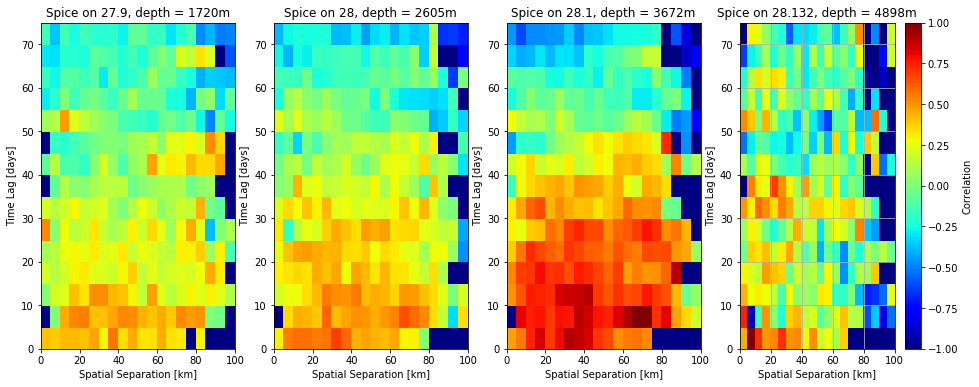

()

In [454]:
# T/S variability (and correlations) on isopycnals 
rho_1 = 27.9, 28, 28.1, 28.132
spice = np.nan * np.ones((lon.shape[1], len(rho_1)))
dep_rec = np.nan * np.ones((lon.shape[1], len(rho_1)))
lon_in = np.nan * np.ones((lon.shape[1], len(rho_1)))
lat_in = np.nan * np.ones((lon.shape[1], len(rho_1)))
for m in range(len(rho_1)):
    for i in range(lon.shape[1]):
        z_on = np.interp(rho_1[m], neutral_density[:, i], grid)
        dep_rec[i, m] = z_on
        sa_in = np.interp(z_on, grid, sa[:, i])
        ct_in = np.interp(z_on, grid, ct[:, i])
        lon_in[i, m] = np.interp(z_on, grid, lon[:, i])
        lat_in[i, m] = np.interp(z_on, grid, lat[:, i])
        spice[i, m] = gsw.spiciness1(sa_in, ct_in)
# ---------------------------
# Mode Amplitude Correlations 
matplotlib.rcParams['figure.figsize'] = (16,6)            
f, ax = plt.subplots(1, 4)
for l in range(len(rho_1)):
    x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (lon_in[:, l] - ref_lon) / 1000
    y = 1852 * 60 * (lat_in[:, l] - ref_lat) / 1000
    x_tile = np.tile(x, (len(x), 1))
    y_tile = np.tile(y, (len(y), 1))
    t = time_rec_bin.copy()
    time_tile = np.tile(time_rec_bin, (len(time_rec_bin), 1))
    dist = np.sqrt((x_tile - x_tile.T) ** 2 + (y_tile - y_tile.T) ** 2) / 1000
    time_lag = np.abs(time_tile - time_tile.T)

    # distances apart
    for i in range(len(x) - 1):
        if i < 1:
            dist_x = x[i+1:] - x[i]
            dist_y = y[i+1:] - y[i]
            dist_t = np.sqrt(dist_x**2 + dist_y**2)
            time_l = np.abs(time_rec_bin[i] - t[i+1:])
            spice_count = np.array((spice[i, l] * np.ones(len(x[i+1:])), spice[i+1:, l]))
        else:
            dist_x = np.concatenate((dist_x, x[i+1:] - x[i]))
            dist_y = np.concatenate((dist_y, y[i + 1:] - y[i]))
            dist_t = np.concatenate((dist_t, np.sqrt((x[i+1:] - x[i])**2 + (y[i + 1:] - y[i])**2)))
            time_l = np.concatenate((time_l, np.abs(t[i] - t[i+1:])))
            spice_count = np.concatenate((spice_count, np.array((spice[i, l] * np.ones(len(x[i + 1:])), spice[i + 1:, l]))), axis=1)
        
    # define each box as all points that fall within a time and space lag
    dist_win = np.arange(-100, 105, 2)
    dist_t_win = np.arange(0, 105, 5)
    t_win = np.arange(0, 80, 2)
    t_t_win = np.arange(0, 80, 5)
    corr_i_z = np.nan * np.zeros((len(t_win), len(dist_win)))
    corr_i_z2 = np.nan * np.zeros((len(t_win), len(dist_win)))
    corr_i_all = np.nan * np.zeros((len(t_t_win), len(dist_t_win)))

    # spatial separation             
    for dd in range(len(dist_t_win) - 1):
        for tt in range(len(t_t_win) - 1):
            in_box = np.where((dist_t > dist_t_win[dd]) & (dist_t < dist_t_win[dd + 1]) &
                                (time_l > t_t_win[tt]) & (time_l < t_t_win[tt + 1]))[0]
            if len(in_box) > 7:
                inski_with = spice_count[:, in_box]
                inski = np.unique(spice_count[:, in_box])
                i_mean = np.nanmean(inski)
                n = len(inski)
                variance = np.nanvar(inski)
                covi = np.nan * np.zeros(np.shape(inski_with)[1])
                for k in range(np.shape(inski_with)[1]):
                    covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
                corr_i_all[tt, dd] = (1 / (n * variance)) * np.nansum(covi)     

    ax[l].pcolor(dist_t_win, t_t_win, corr_i_all, vmin=-1, vmax=1, cmap='jet')
    ax[l].set_xlabel('Spatial Separation [km]')
    ax[l].set_ylabel('Time Lag [days]')
    ax[l].set_title('Spice on ' + str(rho_1[l]) + ', depth = ' + str(np.int(np.nanmean(dep_rec[:, l]))) + 'm')
plt.colorbar(pa, label='Correlation')
plot_pro(ax[l])                  

In [355]:
dep_rec[:, l]

array([ 4900.,  4900.,    nan,    nan,    nan,    nan,    nan,    nan,
        4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,
        4900.,  4900.,    nan,    nan,  4900.,  4900.,  4900.,  4900.,
        4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,
        4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,
        4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,
        4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,
        4900.,  4900.,  4900.,  4900.,  4900.,  4900.,    nan,    nan,
        4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,
        4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,
        4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,
        4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,
        4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,
        4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,  4900.,
      

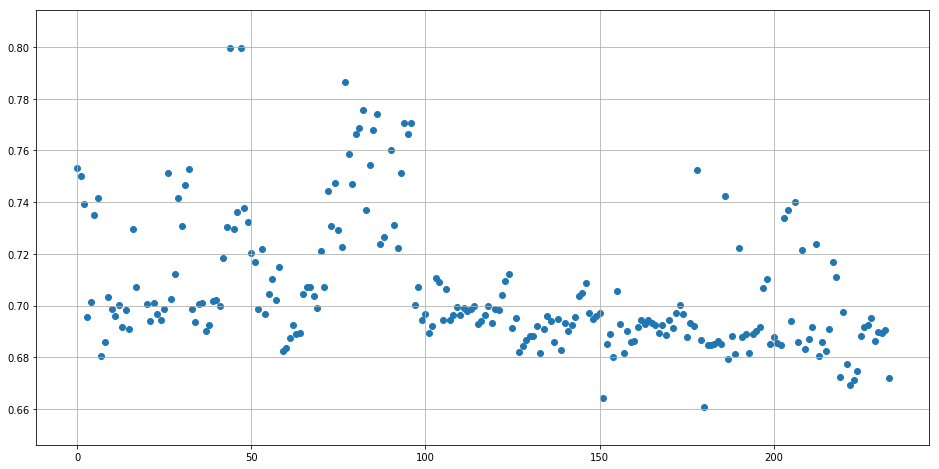

()

In [310]:
f, ax = plt.subplots()
ax.scatter(range(lon.shape[1]), spice)
plot_pro(ax)

In [455]:
# FILTER VELOCITY PROFILES IF THEY ARE TOO NOISY / BAD -- ALSO HAVE TO REMOVE EQUIVALENT ETA PROFILE
good_v = np.zeros(np.shape(dg_v_0)[1], dtype=bool)
for i in range(np.shape(dg_v_0)[1]):
    dv_dz = np.gradient(dg_v_0[10:-20, i], -1 * grid[10:-20])
    if (np.nanmax(np.abs(dv_dz)) < 0.003) & (np.abs(dg_v_0[200, i]) < 0.2) & (np.abs(dg_v_0[20, i]) < 0.5):
        good_v[i] = True

avg_sig = avg_sig0_per_dep[:, good_v]
eta_alt = eta_alt_3[:, good_v]
dace_mw = dace_mw_0[good_v]
dacn_mw = dacn_mw_0[good_v]
dg_v_lon = dg_v_lon_0[good_v]
dg_v_lat = dg_v_lat_0[good_v]
dg_v = dg_v_0[:, good_v]
dg_v_e = dg_v_e_0[:, good_v]
dg_v_n = dg_v_n_0[:, good_v]
dg_mw_time = dg_mw_time_0[good_v]
dg_v_dive_no = dg_v_dive_no_0[good_v]
num_mw_profs = np.shape(eta_alt)[1]

# Smooth DG N2 profiles
dg_avg_N2_coarse = N2_all.copy()
dg_avg_N2_coarse[np.isnan(dg_avg_N2_coarse)] = dg_avg_N2_coarse[~np.isnan(dg_avg_N2_coarse)][0] - 1*10**(-5)
dg_avg_N2 = savgol_filter(dg_avg_N2_coarse, 15, 3)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: All-NaN slice encountered


In [456]:
np.sum(good_v)


75

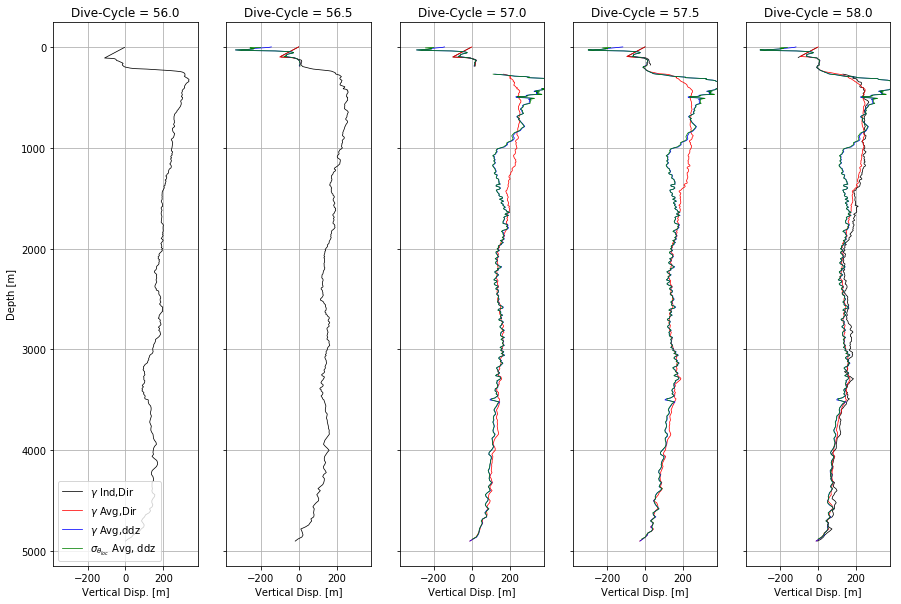

()

In [457]:
# these_profiles = np.array([59, 62.5, 63.5, 69, 77])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([113, 113.5, 114, 114.5, 115])  # dive numbers of profiles to compare (individual dives)
these_profiles = np.array([56. ,   56.5,   57. ,   57.5,   58. ])
# these_profiles = np.array([67, 68, 69, 70, 71])  # dive numbers of profiles to compare (individual dives)
# these_profiles = np.array([72, 72.5, 73, 73.5, 74])  # dive numbers of profiles to compare (individual dives)

plt.rcParams['figure.figsize'] = 15, 10
f, ax = plt.subplots(1, 5, sharey=True)
for i in range(5):
    ind_rel = profile_tags == these_profiles[i]
    avg_rel = dg_v_dive_no_0 == these_profiles[i]
    ax[i].plot(eta_per_prof_3[:, ind_rel], grid, color='k', linewidth=0.75, label=r'$\gamma$ Ind,Dir')  # individual profiles direct search, gamma
    ax[i].plot(eta_alt_3[:, avg_rel], grid, color='r', linewidth=0.75, label=r'$\gamma$ Avg,Dir')  # avg direct search, gamma
    ax[i].plot(-1 * eta_alt_0[:, avg_rel], grid, color='b', linewidth=0.75, label=r'$\gamma$ Avg,ddz')  # avg divide by ddz, gamma
    ax[i].plot(-1 * eta_alt_2[:, avg_rel], grid, color='g', linewidth=0.75, label=r'$\sigma_{\theta_{loc}}$ Avg, ddz')  # avg divide by ddz, pot den, local pref
    ax[i].set_xlim([-380, 380])
    ax[i].set_title('Dive-Cycle = ' + str(these_profiles[i]))
    ax[i].set_xlabel('Vertical Disp. [m]', fontsize=10)

handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, fontsize=10)
ax[0].set_ylabel('Depth [m]')
ax[4].invert_yaxis()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[3].grid()
plot_pro(ax[4])

In [458]:
# --- VERTICAL MODES ---
# --- compute vertical mode shapes
# by season

G_0, Gz_0, c_0, epsilon_0 = vertical_modes(N2[:, 0], grid, omega, mmax)  # fall
G_1, Gz_1, c_1, epsilon_1 = vertical_modes(N2[:, 1], grid, omega, mmax)  # winter
Gs = [G_0, G_1]
Gzs = [Gz_0, Gz_1]
cs = [c_0, c_1]
epsilons = [epsilon_0, epsilon_1]
# test using average over entire year
G_tot, Gz_tot, c_tot, epsilon_tot = vertical_modes(np.nanmean(N2, axis=1), grid, omega, mmax)  # N2

# --- compute alternate vertical modes
bc_bot = 2  # 1 = flat, 2 = rough
grid2 = np.concatenate([np.arange(0, 150, 10), np.arange(150, 300, 10), np.arange(300, 4500, 10)])
n2_interp = np.interp(grid2, grid, dg_avg_N2)
n2_interp[0] = n2_interp[1] - 0.000001
F_int_g2, F_g2, c_ff, norm_constant, epsilon2 = vertical_modes_f(n2_interp, grid2, omega, mmax, bc_bot)
F = np.nan * np.ones((np.size(grid), mmax + 1))
F_int = np.nan * np.ones((np.size(grid), mmax + 1))
for i in range(mmax + 1):
    F[:, i] = np.interp(grid, grid2, F_g2[:, i])
    F_int[:, i] = np.interp(grid, grid2, F_int_g2[:, i])

# --- test season differences in modes
cols = ['#2F4F4F', '#FF4500', '#DAA520', '#800080']
season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [459]:
Avg_sig = avg_sig.copy()
Time2 = dg_mw_time.copy()
V2 = dg_v.copy()
Eta2 = eta_alt.copy()
Eta2_c = eta_alt.copy()
Info2 = dg_v_dive_no.copy()
prof_lon2 = dg_v_lon.copy()
prof_lat2 = dg_v_lat.copy()

# these are the indices that satisfy the different seasons
d2_fall = np.where(Time2 < bd1)[0]
d2_winter = np.where((Time2 > bd1) & (Time2 < bd2))[0]
bckgrds2 = [d2_fall, d2_winter]

In [177]:
eta_fit_depth_max

4000

In [460]:
# ---- PROJECT MODES ONTO EACH PROFILE -------
# ---- Velocity and Eta (ENERGY)
sz = np.shape(Eta2)
num_profs = sz[1]
AG = np.zeros([nmodes, num_profs])
AGz = np.zeros([nmodes, num_profs])
Eta_m = np.nan * np.zeros([np.size(grid), num_profs])
V_m = np.nan * np.zeros([np.size(grid), num_profs])
Neta = np.nan * np.zeros([np.size(grid), num_profs])
NEta_m = np.nan * np.zeros([np.size(grid), num_profs])
PE_per_mass = np.nan * np.zeros([nmodes, num_profs])
HKE_per_mass = np.nan * np.zeros([nmodes, num_profs])
modest = np.arange(11, nmodes)
good_ke_prof = np.ones(num_profs)
good_pe_prof = np.ones(num_profs)
HKE_noise_threshold = 1 * 1e-5  # 1e-5
PE_noise_threshold = 1e5
for i in range(num_profs):
    if len(np.intersect1d(d2_fall, i)):
        G = G_0
        Gz = Gz_0
        c = c_0
    else:
        G = G_1
        Gz = Gz_1
        c = c_1

    # fit to velocity profiles
    this_V = V2[:, i].copy()
    iv = np.where(~np.isnan(this_V))
    if iv[0].size > 1:
        AGz[:, i] = np.squeeze(np.linalg.lstsq(np.squeeze(Gz[iv, :]), np.transpose(np.atleast_2d(this_V[iv])))[0])
        # Gz(iv,:)\V_g(iv,ip)
        V_m[:, i] = np.squeeze(np.matrix(Gz) * np.transpose(np.matrix(AGz[:, i])))
        # Gz*AGz[:,i];
        HKE_per_mass[:, i] = (1 / 2) * (AGz[:, i] * AGz[:, i])
        ival = np.where(HKE_per_mass[modest, i] >= HKE_noise_threshold)
        if np.size(ival) > 0:
            good_ke_prof[i] = 0  # flag profile as noisy
    else:
        good_ke_prof[i] = 0  # flag empty profile as noisy as well

    # fit to eta profiles
    this_eta = Eta2[:, i].copy()
    # obtain matrix of NEta
    Neta[:, i] = N_all * this_eta
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))[0]
    if len(iw) > 1:
        eta_fs = Eta2[:, i].copy()  # ETA

        # -- taper fit as z approaches 0
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0]] / grid[iw[0]]
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))[0]
        lgs = grid[iw[-1]]
        grid_ar = np.nan * np.ones(len(i_dp))
        for oo in range(len(grid[i_dp])):
            grid_ar[oo] = np.int(grid[i_dp[oo]])
        eta_fs[i_dp] = (grid_ar - np.int(grid[-1])) * this_eta[iw[-1]] / (np.int(lgs) - grid[-1])

        # -- solve matrix problem
        AG[1:, i] = np.linalg.lstsq(G[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]
        # AG[1:, i] = np.linalg.lstsq(F_int[:, 1:], eta_fs[:, np.newaxis])[0][:, 0]

        Eta_m[:, i] = np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i])))
        # Eta_m[:, i] = np.squeeze(np.matrix(F_int) * np.transpose(np.matrix(AG[:, i])))
        NEta_m[:, i] = N_all * np.array(np.squeeze(np.matrix(G) * np.transpose(np.matrix(AG[:, i]))))
        PE_per_mass[:, i] = (1 / 2) * AG[:, i] * AG[:, i] * c * c

        np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        iwal = np.where(PE_per_mass[modest, i] >= PE_noise_threshold)
        if np.size(iwal) > 0:
            good_pe_prof[i] = 0  # flag profile as noisy
# end loop over each v and eta for fitting

# check for big problemooooo
# f, ax = plt.subplots()
# ax.plot(Eta2[:, i], grid)
# ax.plot(eta_fs, grid, color='r')
# ax.invert_yaxis()
# plot_pro(ax)

In [461]:
# --- check on mode amplitudes from averaging or individual profiles
mw_time_ordered_i = np.argsort(Time2)
AG_ordered = AG[:, mw_time_ordered_i]
AGz_ordered = AGz[:, mw_time_ordered_i]
Time_ordered = Time2[mw_time_ordered_i]
HKE_per_mass = HKE_per_mass[:, mw_time_ordered_i]
PE_per_mass = PE_per_mass[:, mw_time_ordered_i]
Info3 = Info2[mw_time_ordered_i]
V_ordered = V2[:, mw_time_ordered_i]
Vm_ordered = V_m[:, mw_time_ordered_i]
Eta_ordered = Eta2[:, mw_time_ordered_i]
Etam_ordered = Eta_m[:, mw_time_ordered_i]

In [462]:
# --- EOF of velocity profiles (for whole mission)
check1 = 7      # upper index to include in eof computation
check2 = -10     # lower index to include in eof computation
grid_check = grid[check1:check2]
V4 = V2[check1:check2, :].copy()

checkk = np.zeros(np.shape(V4)[1])
for j in range(np.shape(V4)[1]):
    checkk[j] = np.sum(np.isnan(V4[:, j]))
Uzq = V4[:, checkk < 1].copy()

nq = np.size(Uzq[0, :])
avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
Uzqa = Uzq - np.transpose(np.tile(avg_Uzq, [nq, 1]))
cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
D_Uzqa, V_Uzqa = np.linalg.eig(cov_Uzqa)

t1 = np.real(D_Uzqa[0:10])
PEV = t1 / np.sum(t1)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


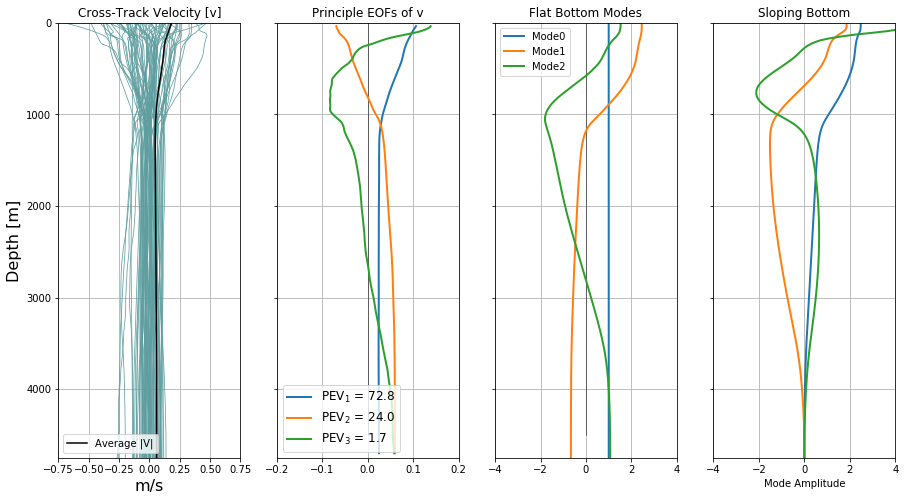

In [463]:
# --- plot velocity EOFs 
matplotlib.rcParams['figure.figsize'] = (15,8)
f, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
for i in range(np.shape(V2)[1]):
    ax.plot(V2[:, i], grid, color='#5F9EA0', linewidth=0.75)
ax.plot(np.nanmean(np.abs(V2), axis=1), grid, color='k', label='Average |V|')
ax.set_xlim([-.75, .75])
ax.set_ylim([0, 4750])
ax.set_title('Cross-Track Velocity [v]', fontsize=12)
ax.set_xlabel('m/s', fontsize=16)
ax.set_ylabel('Depth [m]', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)

ax2.plot(np.zeros(10), np.arange(0, 5000, 500), color='k', linewidth=0.5)
ax3.plot(np.zeros(10), np.arange(0, 5000, 500), color='k', linewidth=0.5)
colorm = 'r', 'b', 'g'
for i in range(3):
    ax2.plot(V_Uzqa[:, i], grid_check, label=r'PEV$_{' + str(i + 1) + '}$ = ' + str(100 * np.round(PEV[i], 3)),
                linewidth=2)
    ax3.plot(Gz[:, i], grid, label='Mode' + str(i), linewidth=2)
    ax4.plot(F[:, i], grid, label='Mode' + str(i), linewidth=2)

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, fontsize=12)
ax2.set_xlim([-.2, .2])
ax2.set_title('Principle EOFs of v', fontsize=12)
# ax2.set_xlabel('m/s', fontsize=16)
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, fontsize=10)
ax3.set_xlim([-4, 4])
ax3.set_title('Flat Bottom Modes', fontsize=12)
# ax3.set_xlabel('[m]', fontsize=10)
ax4.set_title('Sloping Bottom', fontsize=12)
ax4.set_xlabel('Mode Amplitude', fontsize=10)
ax4.set_xlim([-4, 4])
ax.grid()
ax2.grid()
ax3.grid()
ax.invert_yaxis()
plot_pro(ax4)
f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_3_27_19/36n_v_eof_tot.jpg", dpi=300)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Optimization terminated successfully.
         Current function value: 0.013436
         Iterations: 20
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 0.009970
         Iterations: 8
         Function evaluations: 16
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Optimization terminated successfully.
         Current function value: 0.051396
         Iterations: 24
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: 0.508438
         Iterations: 8
         Function evaluations: 16
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Optimization terminated successfully.
         Current function value: 0.013889
         Iterations: 39
         Function evaluations: 74
Optimization terminated successfully.
         Current function value: 0.033320
         Iterations: 15
         Function evaluations: 30
[ 0.  0.  0.  0.  0.  0.

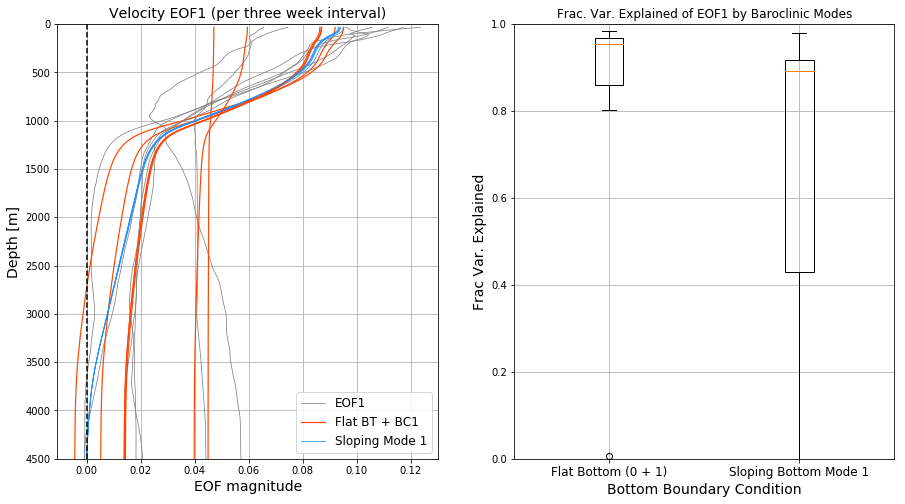

()

In [464]:
# --- EOF of velocity profiles (in two week intervals) ---
def functi_1(p, xe, xb):
    #  This is the target function that needs to be minimized
    fsq = (xe - p*xb)**2
    return fsq.sum()

def functi_2(p, xe, xb, xs):
    #  This is the target function that needs to be minimized
    fsq = (xe - (p[0] * xb + p[1] * xs)) ** 2
    # fsq = (xe - p*xb)**2
    return fsq.sum()

# loop over every two weeks (to obtain statistics)
T_week = np.arange(Time2.min(), Time2.max(), 21)
check1 = 7      # upper index to include in eof computation
check2 = -10    # lower index to include in eof computation
grid_check = grid[check1:check2]
Uzq = V2[check1:check2, :].copy()

PEV_per = np.nan * np.ones((len(T_week) - 1, 10))
fvu1_per = np.nan * np.ones(len(T_week) - 1)
fvu2_per = np.nan * np.ones(len(T_week) - 1)
bc1 = Gz[check1:check2, 0]  # flat bottom (modes 0)
bc11 = + Gz[check1:check2, 1]  # flat bottom (modes 1)
bc2 = F[check1:check2, 0]  # sloping bottom  (modes 1 + 2 ... there is no barotropic mode)
f, (ax, ax1) = plt.subplots(1, 2)
AGz_eof = np.nan * np.ones((nmodes, len(T_week) - 1))
AF_eof = np.nan * np.ones((nmodes, len(T_week) - 1))
for i in range(len(T_week) - 1):
    if i >= (len(T_week) - 2):
        V4 = Uzq[:, (Time_ordered > T_week[i])].copy()
    else:
        V4 = Uzq[:, (Time_ordered > T_week[i]) & (Time_ordered < T_week[i + 1])].copy()
    checkk = np.zeros(np.shape(V4)[1])
    for j in range(np.shape(V4)[1]):
        checkk[j] = np.sum(np.isnan(V4[:, j]))
    V4 = V4[:, checkk < 1]    
    
    print(checkk)
    nq = np.size(V4[0, :])
    avg_Uzq = np.nanmean(np.transpose(Uzq), axis=0)
    Uzqa = V4 - np.transpose(np.tile(avg_Uzq, [nq, 1]))
    cov_Uzqa = (1 / nq) * np.matrix(Uzqa) * np.matrix(np.transpose(Uzqa))
    D_Uzqa, V_Uzqa = np.linalg.eig(cov_Uzqa)
    t1 = np.real(D_Uzqa[0:10])
    # percent explained variance by each eof
    PEV_per[i, :] = (t1 / np.sum(t1))
    # percent variance explained of each eof by baroclinic modes with either bottom boundary condition
    eof1 = np.array(np.real(V_Uzqa[:, 0]))
    # -- minimize mode shapes onto eof shape
    p = np.array([0.8 * eof1.min() / np.max(np.abs(F[:, 0])), 0.8 * eof1.min() / np.max(np.abs(F[:, 0]))])
    p2 = 0.8 * eof1.min() / np.max(np.abs(F[:, 0]))
    ins1 = np.transpose(np.concatenate([eof1, bc1[:, np.newaxis], bc11[:, np.newaxis]], axis=1))
    ins2 = np.transpose(np.concatenate([eof1, bc2[:, np.newaxis]], axis=1))
    min_p1 = fmin(functi_2, p, args=(tuple(ins1)))
    min_p2 = fmin(functi_1, p2, args=(tuple(ins2)))
    fvu1_per[i] = 1 - (np.sum((eof1[:, 0] - (bc1 * min_p1[0] + bc11 * min_p1[1])) ** 2) /
                    np.sum((eof1 - np.mean(eof1)) ** 2))
    fvu2_per[i] = 1 - (np.sum((eof1[:, 0] - bc2 * min_p2) ** 2) / np.sum((eof1 - np.mean(eof1)) ** 2))

    if np.nanmean(bc1[0:6] * min_p1[0] + bc11[0:6] * min_p1[1]) < 0:  # np.nanmean(eof1[0:20] < 0):
        if fvu1_per[i] > 0:
            ax.plot(-1 * eof1, grid_check, color='#808080', linewidth=0.75, label='EOF1')
            ax.plot(-1 * (bc1 * min_p1[0] + bc11 * min_p1[1]), grid_check, color='#FF4500', linewidth=1.2, label='Flat BT + BC1')
        if fvu2_per[i] > 0:
            ax.plot(-1 * bc2 * min_p2, grid_check, color='#1E90FF', linewidth=0.75, label='Sloping Mode 1')
    else:
        if fvu1_per[i] > 0:
            ax.plot(eof1, grid_check, color='#808080', linewidth=0.75, label='EOF1')
            ax.plot((bc1 * min_p1[0] + bc11 * min_p1[1]), grid_check, color='#FF4500', linewidth=1.2, label='Flat BT + BC1')
        if fvu2_per[i] > 0:
            ax.plot(bc2 * min_p2, grid_check, color='#1E90FF', linewidth=0.75, label='Sloping Mode 1')
ax.plot([0, 0], [0, 4500], color='k', linestyle='--')
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0], handles[1], handles[2]], [labels[0], labels[1], labels[2]], fontsize=12)
ax.set_title('Velocity EOF1 (per three week interval)', fontsize=14)
ax.set_ylabel('Depth [m]', fontsize=14)
ax.set_xlabel('EOF magnitude', fontsize=14)
ax.set_ylim([0, 4500])
ax.invert_yaxis()

fvu1_per[fvu1_per < 0] = 0.
fvu2_per[fvu2_per < 0] = 0.

ax1.boxplot([fvu1_per[~np.isnan(fvu1_per)], fvu2_per[~np.isnan(fvu2_per)]])  # fvu1_per[:, None]
ax1.set_ylim([0, 1])
ax1.set_title('Frac. Var. Explained of EOF1 by Baroclinic Modes')
ax1.set_xlabel('Bottom Boundary Condition', fontsize=14)
ax1.set_ylabel('Frac Var. Explained', fontsize=14)
ax1.set_xticklabels(['Flat Bottom (0 + 1)', 'Sloping Bottom Mode 1'], fontsize=12)
# ax2.set_title('Bottom Boundary Condition')
# ax2.set_ylabel('Frac Var. Explained by Mode Shapes')
# ax2.set_ylim([0, 1])
ax.grid()
plot_pro(ax1)

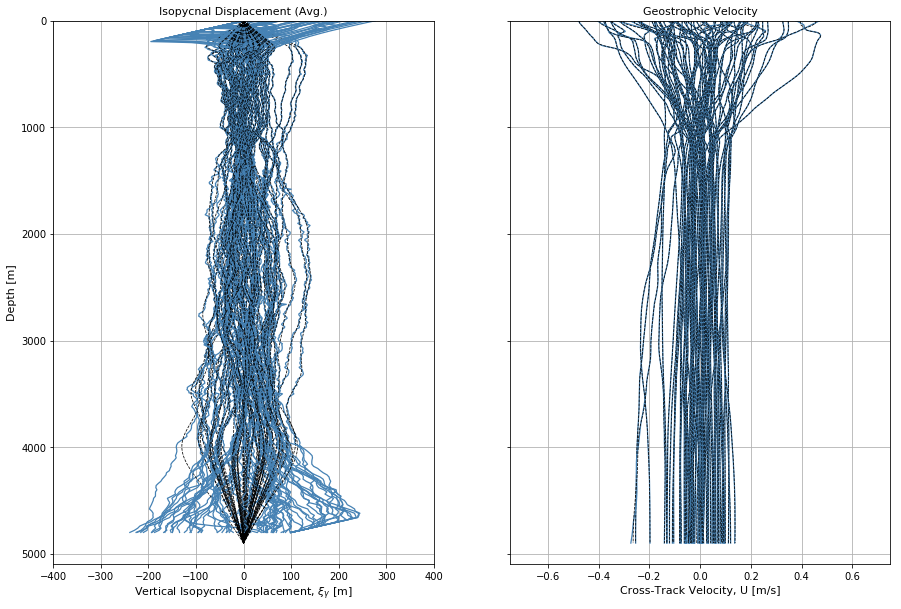

()

In [465]:
# plot eta 
plt.rcParams['figure.figsize'] = 15, 10
f_eta, (ax1, ax0) = plt.subplots(1, 2, sharey=True)
pzmax = -5
for j in range(num_profs):
    ax1.plot(Eta2[0:pzmax, j], grid[0:pzmax], color='#4682B4', linewidth=1.25)
    ax1.plot(Eta_m[:, j], grid, color='k', linestyle='--', linewidth=.75)
    if good_ke_prof[j] > 0:
        ax0.plot(V2[:, j], grid, color='#4682B4', linewidth=1.25)
        ax0.plot(V_m[:, j], grid, color='k', linestyle='--', linewidth=.75)

ax1.set_xlim([-400, 400]) 
ax1.set_ylim([0, 5100])
ax1.invert_yaxis()
ax1.grid()
ax0.set_xlim([-.75, .75])
ax0.set_title("Geostrophic Velocity", fontsize=11)  # (" + str(num_profs) + 'profiles)' )
ax0.set_xlabel('Cross-Track Velocity, U [m/s]', fontsize=11)
ax1.set_xlabel(r'Vertical Isopycnal Displacement, $\xi_{\gamma}$ [m]', fontsize=11)
ax1.set_title(r'Isopycnal Displacement (Avg.)', fontsize=11)
ax1.set_ylabel('Depth [m]', fontsize=11)
plot_pro(ax0)   

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


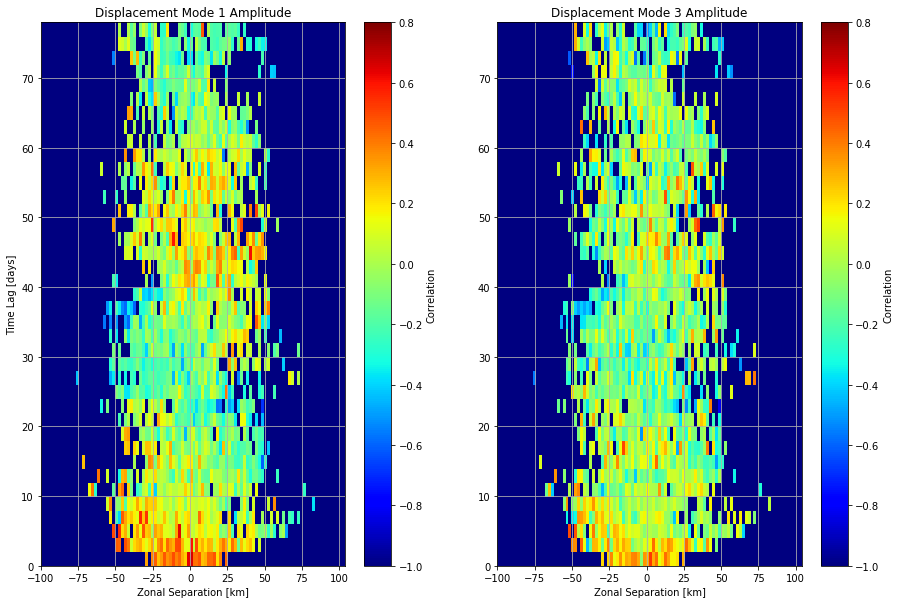

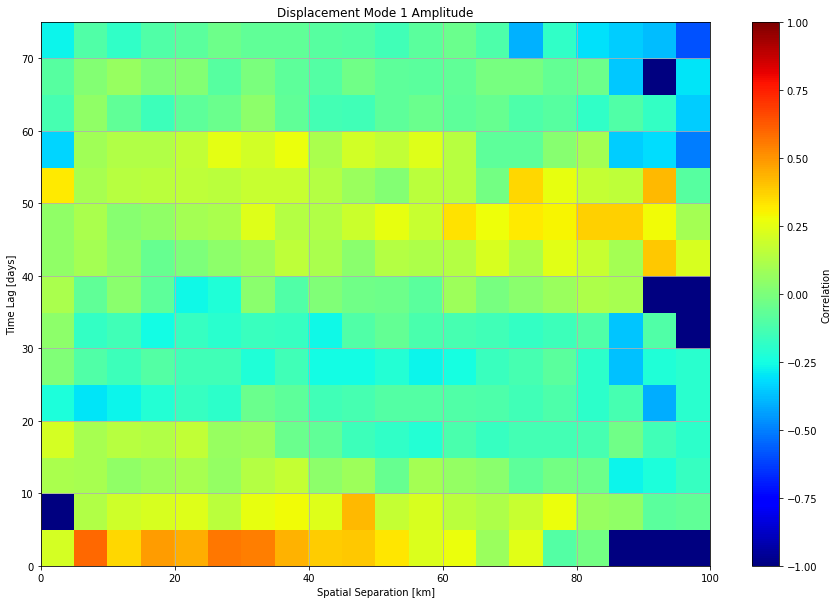

()

In [466]:
# Mode Amplitude Correlations 
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (prof_lon_i - ref_lon)
y = 1852 * 60 * (prof_lat_i - ref_lat)
x_tile = np.tile(x, (len(x), 1))
y_tile = np.tile(y, (len(y), 1))
time_tile = np.tile(time_rec_bin, (len(time_rec_bin), 1))
dist = np.sqrt((x_tile - x_tile.T) ** 2 + (y_tile - y_tile.T) ** 2) / 1000
time_lag = np.abs(time_tile - time_tile.T)

# redo with only zonal separation
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (prof_lon_i - ref_lon) / 1000
y = 1852 * 60 * (prof_lat_i - ref_lat) / 1000
t = time_rec_bin.copy()
AG_i = AG_all[1, :]
AG_ii = AG_all[3, :]

# distances apart
# dist_x = np.nan * np.zeros((len(x), len(x)))
# time_l = np.nan * np.zeros((len(x), len(x)))
for i in range(len(x) - 1):
    if i < 1:
        dist_x = x[i+1:] - x[i]
        dist_y = y[i+1:] - y[i]
        dist_t = np.sqrt(dist_x**2 + dist_y**2)
        time_l = np.abs(time_rec_bin[i] - t[i+1:])
        AG_count = np.array((AG_i[i] * np.ones(len(x[i+1:])), AG_i[i+1:]))
        AG_count2 = np.array((AG_ii[i] * np.ones(len(x[i + 1:])), AG_ii[i + 1:]))
    else:
        dist_x = np.concatenate((dist_x, x[i+1:] - x[i]))
        dist_y = np.concatenate((dist_y, y[i + 1:] - y[i]))
        dist_t = np.concatenate((dist_t, np.sqrt((x[i+1:] - x[i])**2 + (y[i + 1:] - y[i])**2)))
        time_l = np.concatenate((time_l, np.abs(t[i] - t[i+1:])))
        AG_count = np.concatenate((AG_count, np.array((AG_i[i] * np.ones(len(x[i + 1:])), AG_i[i + 1:]))), axis=1)
        AG_count2 = np.concatenate((AG_count2, 
                                    np.array((AG_ii[i] * np.ones(len(x[i + 1:])), AG_ii[i + 1:]))), axis=1)
        
# define each box as all points that fall within a time and space lag
dist_win = np.arange(-100, 105, 2)
dist_t_win = np.arange(0, 105, 5)
t_win = np.arange(0, 80, 2)
t_t_win = np.arange(0, 80, 5)
corr_i_z = np.nan * np.zeros((len(t_win), len(dist_win)))
corr_i_z2 = np.nan * np.zeros((len(t_win), len(dist_win)))
corr_i_all = np.nan * np.zeros((len(t_t_win), len(dist_t_win)))
for dd in range(len(dist_win) - 1):
    for tt in range(len(t_win) - 1):
        in_box = np.where((dist_x > dist_win[dd]) & (dist_x < dist_win[dd + 1]) & 
                          (time_l > t_win[tt]) & (time_l < t_win[tt + 1]))[0]
        if len(in_box) > 4:
            inski_with = AG_count[:, in_box]
            inski = np.unique(AG_count[:, in_box])
            i_mean = np.nanmean(inski)
            n = len(inski)
            variance = np.nanvar(inski)
            covi = np.nan * np.zeros(len(inski))
            for k in range(np.shape(inski_with)[1]):
                covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
            corr_i_z[tt, dd] = (1 / (n * variance)) * np.nansum(covi)

            inski_with = AG_count2[:, in_box]
            inski = np.unique(AG_count2[:, in_box])
            i_mean = np.nanmean(inski)
            n = len(inski)
            variance = np.nanvar(inski)
            covi = np.nan * np.zeros(np.shape(inski_with)[1])
            for k in range(np.shape(inski_with)[1]):
                covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
            corr_i_z2[tt, dd] = (1 / (n * variance)) * np.nansum(covi)   
            
for dd in range(len(dist_t_win) - 1):
    for tt in range(len(t_t_win) - 1):
        in_box = np.where((dist_t > dist_t_win[dd]) & (dist_t < dist_t_win[dd + 1]) &
                            (time_l > t_t_win[tt]) & (time_l < t_t_win[tt + 1]))[0]
        if len(in_box) > 5:
            inski_with = AG_count[:, in_box]
            inski = np.unique(AG_count[:, in_box])
            i_mean = np.nanmean(inski)
            n = len(inski)
            variance = np.nanvar(inski)
            covi = np.nan * np.zeros(np.shape(inski_with)[1])
            for k in range(np.shape(inski_with)[1]):
                covi[k] = (inski_with[0, k] - i_mean) * (inski_with[1, k] - i_mean)
            corr_i_all[tt, dd] = (1 / (n * variance)) * np.nansum(covi)    
            
f, (ax1, ax2) = plt.subplots(1, 2)
pa = ax1.pcolor(dist_win, t_win, corr_i_z, vmin=-1, vmax=.8, cmap='jet')
pa2 = ax2.pcolor(dist_win, t_win, corr_i_z2, vmin=-1, vmax=.8, cmap='jet')
ax1.set_xlabel('Zonal Separation [km]')
ax1.set_ylabel('Time Lag [days]')
ax2.set_xlabel('Zonal Separation [km]')
ax1.set_title('Displacement Mode 1 Amplitude')
ax2.set_title('Displacement Mode 3 Amplitude')
f.colorbar(pa, ax=ax1, label='Correlation')
f.colorbar(pa2, ax=ax2, label='Correlation')
ax1.grid()
plot_pro(ax2)

f, ax1 = plt.subplots()
pa = ax1.pcolor(dist_t_win, t_t_win, corr_i_all, vmin=-1, vmax=1, cmap='jet')
ax1.set_xlabel('Spatial Separation [km]')
ax1.set_ylabel('Time Lag [days]')
ax1.set_title('Displacement Mode 1 Amplitude')
plt.colorbar(pa, label='Correlation')
plot_pro(ax1)       

In [467]:
# ----------------------------------------------------------------------------------------------------------------------
# --- ENERGY SPECTRA ---
# ----------------------------------------------------------------------------------------------------------------------
# -- initial params
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
dk = f_ref / c_tot[1]
sc_x = 1000 * f_ref / c_tot[1:]

# --- PE, KE selection (exclude eddy)
HKE_per_mass_0 = HKE_per_mass.copy()
PE_per_mass_0 = PE_per_mass.copy()
# HKE_per_mass = HKE_per_mass[:, np.where(good_ke_prof > 0)[0]]
# PE_per_mass = PE_per_mass[:, np.where(good_ke_prof > 0)[0]]
used_profiles = dg_v_dive_no[good_ke_prof > 0]
calmer = np.where((Info2 < 60) | (Info2 >= 71) & (good_ke_prof > 0))[0]  # excl. labby
# calmer = np.arange(0, np.int(np.sum(good_ke_prof)))
avg_PE = np.nanmean(PE_per_mass[:, calmer], 1)
avg_KE = np.nanmean(HKE_per_mass[:, calmer], 1)

# --- ENERGY parameters ---
vert_wavenumber = f_ref / c[1:]
dk_ke = 1000 * f_ref / c[1]
k_h = 1e3 * (f_ref / c[1:]) * np.sqrt(avg_KE[1:] / avg_PE[1:])
PE_SD, PE_GM, GMPE, GMKE = PE_Tide_GM(rho0, grid, nmodes, np.transpose(np.atleast_2d(N2_all)), f_ref)
vert_wave = sc_x / 1000
alpha = 10
mu = 1.88e-3 / (1 + 0.03222 * np.nanmean(theta_avg, axis=1) +
                0.002377 * np.nanmean(theta_avg, axis=1) * np.nanmean(theta_avg, axis=1))
nu = mu / gsw.rho(np.nanmean(salin_avg, axis=1), np.nanmean(cons_t_avg, axis=1), grid_p)
avg_nu = np.nanmean(nu)


# --- most and least energetic profiles
KE_i = HKE_per_mass[:, calmer]
PE_i = PE_per_mass[:, calmer]
KE_it = np.nan * np.ones(KE_i.shape[1])
PE_it = np.nan * np.ones(KE_i.shape[1])
for i in range(KE_i.shape[1]):
    KE_it[i] = np.trapz(KE_i[1:, i] + PE_i[1:, i], 1000 * f_ref / c[1:])
    PE_it[i] = np.trapz(PE_i[1:, i], 1000 * f_ref / c[1:])
KE_i_max = np.where(KE_it == np.nanmax(KE_it))[0]
KE_i_min = np.where(KE_it == np.nanmin(KE_it))[0]
PE_i_max = np.where(PE_it == np.nanmax(PE_it))[0]
PE_i_min = np.where(PE_it == np.nanmin(PE_it))[0]
k_h_max = 1e3 * (f_ref / c[1:]) * np.sqrt(np.squeeze(KE_i[1:, KE_i_max]) / np.squeeze(PE_i[1:, KE_i_max]))
k_h_min = 1e3 * (f_ref / c[1:]) * np.sqrt(np.squeeze(KE_i[1:, KE_i_min]) / np.squeeze(PE_i[1:, KE_i_min]))

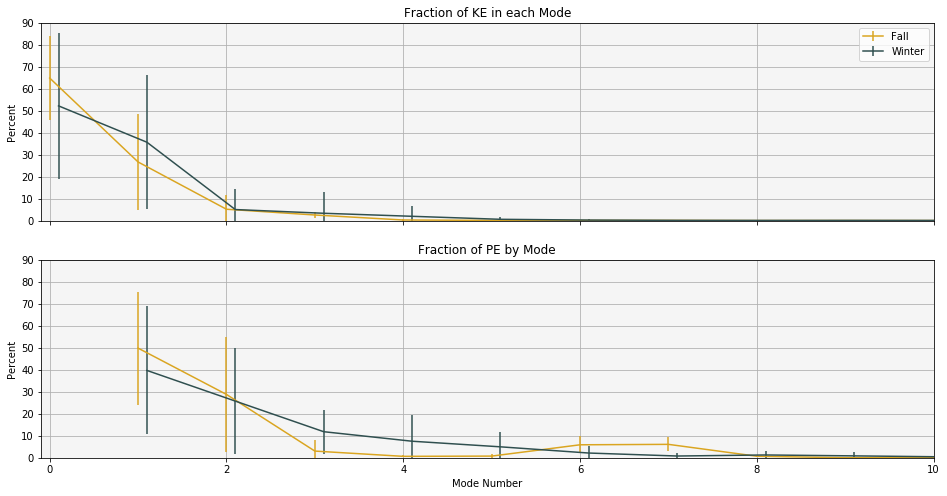

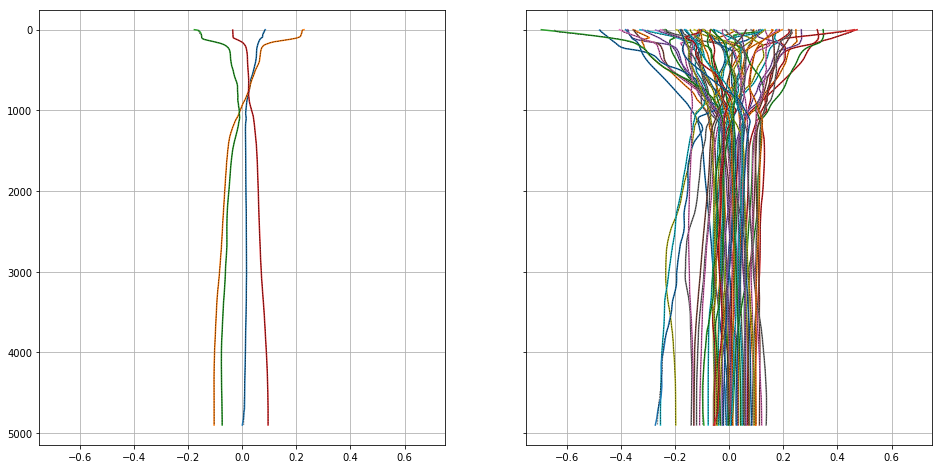

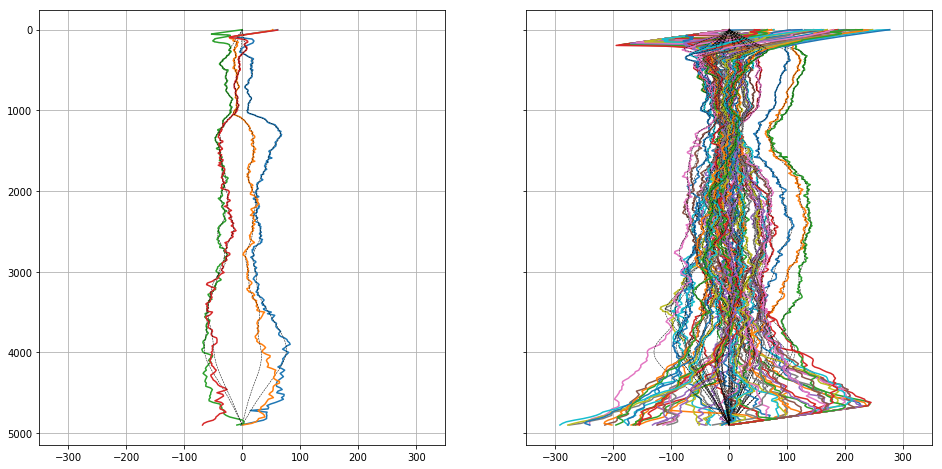

()

In [471]:
# --- Partition KE, PE by season (like bats) ---

# fall
d_fall = np.where((Time_ordered <= bd1) & ((Info3 < 55) | (Info3 > 65)))[0]
# Winter
d_win1 = np.where((Time_ordered > bd1) & (Time_ordered < bd2))[0]
# combine
bckgrds = [d_fall, d_win1]  # KEY!! 4, sets of profiles
k_h_fall = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[0]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[0]], axis=1))
k_h_win1 = 1e3 * (f_ref / c[1:]) * np.sqrt(np.nanmean(HKE_per_mass_0[1:, bckgrds[1]], axis=1) /
                                           np.nanmean(PE_per_mass_0[1:, bckgrds[1]], axis=1))

# --- RATIO of KE_i / KE_total
KE_fraction_f = 100 * HKE_per_mass_0[:, bckgrds[0]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[0]],
                                                                         axis=0), (nmodes, 1))
KE_fraction_w1 = 100 * HKE_per_mass_0[:, bckgrds[1]] / np.tile(np.nansum(HKE_per_mass_0[:, bckgrds[1]],
                                                                         axis=0), (nmodes, 1))
PE_fraction_f = 100 * PE_per_mass_0[:, bckgrds[0]] / np.tile(np.nansum(PE_per_mass_0[:, bckgrds[0]],
                                                                        axis=0), (nmodes, 1))
PE_fraction_w1 = 100 * PE_per_mass_0[:, bckgrds[1]] / np.tile(np.nansum(PE_per_mass_0[:, bckgrds[1]],
                                                                        axis=0), (nmodes, 1))

cols = ['#DAA520', '#2F4F4F', '#800080', '#2F4F4F', '#FF4500', ]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_facecolor('#F5F5F5')
ax1.errorbar(np.arange(0, nmodes), np.nanmean(KE_fraction_f, axis=1), yerr=np.nanstd(KE_fraction_f, axis=1), label='Fall', color=cols[0])
ax1.errorbar(np.arange(0, nmodes) + .1, np.nanmean(KE_fraction_w1, axis=1), yerr=np.nanstd(KE_fraction_w1, axis=1), label='Winter', color=cols[1])
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
ax1.set_ylim([0, 90])
ax1.set_xlim([-.1, 10])
ax1.set_title('Fraction of KE in each Mode')
ax1.set_ylabel('Percent')
ax1.grid()
ax2.set_facecolor('#F5F5F5')
ax2.errorbar(np.arange(1, nmodes), np.nanmean(PE_fraction_f[1:, :], axis=1), yerr=np.nanstd(PE_fraction_f[1:, :], axis=1), color=cols[0])
ax2.errorbar(np.arange(1, nmodes) + .1, np.nanmean(PE_fraction_w1[1:, :], axis=1), yerr=np.nanstd(PE_fraction_w1[1:, :], axis=1), color=cols[1])
ax2.set_ylim([0, 90])
ax2.set_title('Fraction of PE by Mode')
ax2.set_ylabel('Percent')
ax2.set_xlabel('Mode Number')
plot_pro(ax2)

# velocity profiles by season 
f, ax = plt.subplots(1, 2, sharey=True)
for i in range(2):
    vin = V_ordered[:, bckgrds[i]]
    vin_m = Vm_ordered[:, bckgrds[i]]
    for j in range(np.shape(V_ordered[:, bckgrds[i]])[1]):
        ax[i].plot(vin[:, j], grid)
        ax[i].plot(vin_m[:, j], grid, linestyle='--', color='k', linewidth=0.5)
    ax[i].set_xlim([-0.75, 0.75])
ax[0].grid()
ax[0].invert_yaxis()
plot_pro(ax[1])

# displacement profiles by season 
f, ax = plt.subplots(1, 2, sharey=True)
for i in range(2):
    vin = Eta_ordered[:, bckgrds[i]]
    vin_m = Etam_ordered[:, bckgrds[i]]
    for j in range(np.shape(V_ordered[:, bckgrds[i]])[1]):
        ax[i].plot(vin[:, j], grid)
        ax[i].plot(vin_m[:, j], grid, linestyle='--', color='k', linewidth=0.5)
    ax[i].set_xlim([-350, 350])
ax[0].grid()
ax[0].invert_yaxis()
plot_pro(ax[1])

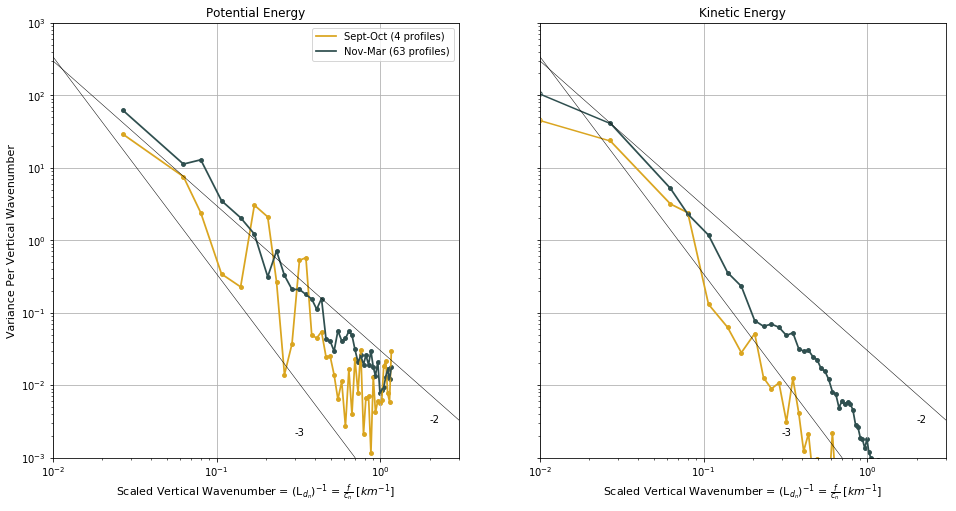

()

In [472]:
# --- PLOT ENERGY BY SEASON

matplotlib.rcParams['figure.figsize'] = (16,8)

f_s_en, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
labs = 'Sept-Oct (' + str(np.shape(d_fall)[0]) + ' profiles)', 'Nov-Mar (' + str(np.shape(d_win1)[0]) + ' profiles)'
lw = [1.75, 1.75, 1.75, .8]
scz = [15, 15, 15, 6]
seasonal_PE_output = np.nan * np.ones((nmodes, len(bckgrds)))
seasonal_KE_output = np.nan * np.ones((nmodes, len(bckgrds)))
for i in range(len(bckgrds)):
    inn = bckgrds[i]
    ax1.plot(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], label=labs[i], linewidth=lw[i])
    ax1.scatter(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], s=scz[i])
    ax2.plot(sc_x, np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], label=labs[i], linewidth=lw[i])
    ax2.scatter(sc_x, np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=cols[i], s=scz[i])
    ax2.plot([10**-2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0:2] / dk, color=cols[i], linewidth=1.5)
    ax2.scatter(10**-2, np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0] / dk, color=cols[i], s=scz[i]*1.5, facecolors='none')
    seasonal_PE_output[1:, i] = np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk
    seasonal_KE_output[1:, i] = np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk
    seasonal_KE_output[0, i] = np.nanmean(HKE_per_mass_0[:, inn], axis=1)[0] / dk
# -- GM
# ax1.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * PE_GM_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
# ax1.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * PE_GM_bats[1] / sta_bats_dk, r'$1/4 PE_{GM}$', fontsize=10)
# ax2.plot(1000 * sta_bats_f / sta_bats_c[1:], 0.25 * GMKE_bats / sta_bats_dk, color='k', linewidth=0.75, linestyle='--')
# ax2.text(1000 * sta_bats_f / sta_bats_c[1] - .01, 0.5 * GMKE_bats[1] / sta_bats_dk, r'$1/4 KE_{GM}$', fontsize=10)    
ax1.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax1.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax1.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax1.text(2*10**0, 3*10**-3, '-2', fontsize=10)
ax2.plot([7 * 10**-3, 7 * 10**-1], [10**3, 10**-3], color='k', linewidth=0.5)
ax2.text(3*10**-1, 2*10**-3, '-3', fontsize=10)
ax2.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax2.text(2*10**0, 3*10**-3, '-2', fontsize=10)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=10)
ax1.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=11)
ax1.set_ylabel('Variance Per Vertical Wavenumber', fontsize=11)
ax1.set_title('Potential Energy')
ax1.set_xlim([10 ** -2, 3 * 10 ** 0])
ax1.set_ylim([10 ** (-3), 1 * 10 ** 3])
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=11)
ax2.set_title('Kinetic Energy')
ax2.set_xlim([10 ** -2, 3 * 10 ** 0])
ax2.set_xscale('log')
ax1.grid()
plot_pro(ax2)

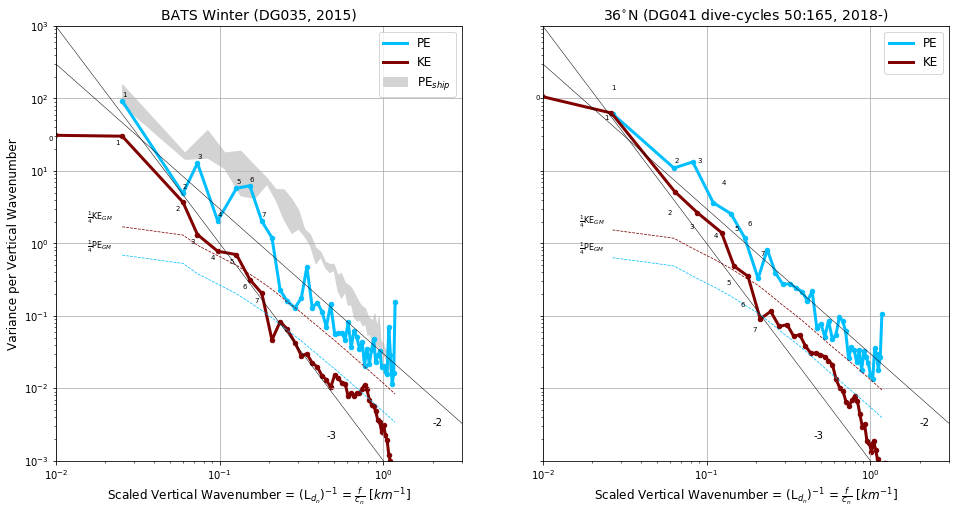

()

In [186]:
# - load BATS
pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg035_2015_energy_apr2019.pkl', 'rb')
DGB = pickle.load(pkl_file)
pkl_file.close()
bats_dg_KE = DGB['KE']
bats_dg_PE = DGB['PE']
bats_dg_bckgrds = DGB['background_eddy_indicies_for_energy'][0]  # winter index
bats_dg_KE_all = np.nanmean(DGB['KE_all'][:, bats_dg_bckgrds], axis=1)
bats_dg_PE_all = np.nanmean(DGB['PE_all'][:, bats_dg_bckgrds], axis=1)
bats_dg_c = DGB['c']
bats_dg_f = DGB['f']
bats_dg_depth = DGB['depth']
bats_dg_GMKE = DGB['GMKE']
bats_dg_GMPE = DGB['GMPE']
dk_bats = bats_dg_f / bats_dg_c[1]
sc_x_bats = 1000 * bats_dg_f / bats_dg_c[1:]

# -- load in Station BATs PE Comparison
pkl_file = open('/Users/jake/Desktop/bats/station_bats_pe_jan30.pkl', 'rb')
SB = pickle.load(pkl_file)
pkl_file.close()
sta_bats_pe = SB['PE_by_season']
sta_bats_c = SB['c']
sta_bats_f = np.pi * np.sin(np.deg2rad(31.6)) / (12 * 1800)
sta_bats_dk = sta_bats_f / sta_bats_c[1]
# seasonal and variable spread at bats station for each mode
sta_max = np.nan * np.ones(len(sc_x))
sta_min = np.nan * np.ones(len(sc_x))
dg_per_max = np.nan * np.ones(len(sc_x))
dg_per_min = np.nan * np.ones(len(sc_x))
for i in range(1, mmax+1):
    test1 = np.nanmean(sta_bats_pe[0][i, :])
    test2 = np.nanmean(sta_bats_pe[1][i, :])
    test3 = np.nanmean(sta_bats_pe[2][i, :])
    # test4 = np.nanmean(sta_bats_pe[3][i, :])
    sta_max[i - 1] = np.max([test1, test2, test3])
    sta_min[i - 1] = np.min([test1, test2, test3])
    dg_per_max[i - 1] = np.nanmax(PE_per_mass_all[i, :])
    dg_per_min[i - 1] = np.nanmin(PE_per_mass_all[i, :])

# --------------------------------------------------------------------
# - comparison plot of 36N and BATS
fig0, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Station (by season)
ax0.fill_between(1000 * sta_bats_f / sta_bats_c[1:mmax + 1], sta_min / sta_bats_dk, sta_max / sta_bats_dk,
                 label='PE$_{ship}$', color='#D3D3D3')
scols = ['#00BFFF', '#6B8E23', '#800000']
# DG PE avg. (36N)
inn = bckgrds[1]
PE_p = ax1.plot(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=scols[0], label='PE', linewidth=3)
ax1.scatter(sc_x, np.nanmean(PE_per_mass_0[1:, inn], axis=1) / dk, color=scols[0], s=20)
# DG KE (36N)
KE_p = ax1.plot(1000 * f_ref / c[1:], np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=scols[2], label='KE', linewidth=3)
ax1.scatter(1000 * f_ref / c[1:], np.nanmean(HKE_per_mass_0[1:, inn], axis=1) / dk, color=scols[2], s=20)                                         # DG KE
KE_p = ax1.plot([10 ** -2, 1000 * f_ref / c[1]], np.nanmean(HKE_per_mass_0[0:2, inn], axis=1) / dk, color=scols[2], linewidth=3)        # DG KE_0
ax1.scatter(10 ** -2, np.nanmean(HKE_per_mass_0[0, inn]) / dk, color=scols[2], s=20, facecolors='none')                   # DG KE_0

# DG PE avg. (BATS)
ax0.plot(sc_x_bats, bats_dg_PE_all[1:] / dk_bats, color=scols[0], label='PE', linewidth=3)
ax0.scatter(sc_x_bats, bats_dg_PE_all[1:] / dk_bats, color=scols[0], s=20)
# DG KE (BATS)
ax0.plot(1000 * bats_dg_f / bats_dg_c[1:], bats_dg_KE_all[1:] / dk_bats, color=scols[2], label=r'KE', linewidth=3)
ax0.scatter(sc_x_bats, bats_dg_KE_all[1:] / dk_bats, color=scols[2], s=20)                                         # DG KE
ax0.plot([10 ** -2, 1000 * bats_dg_f / bats_dg_c[1]], bats_dg_KE_all[0:2] / dk_bats, color=scols[2], linewidth=3)        # DG KE_0
ax0.scatter(10 ** -2, bats_dg_KE_all[0] / dk_bats, color=scols[2], s=20, facecolors='none')                   # DG KE_0
nums = '1', '2', '3', '4', '5', '6', '7', '8'
for i in range(1, 8):
    ax0.text( (1000 * bats_dg_f / bats_dg_c[i]) - (1/10)*(1000 * bats_dg_f / bats_dg_c[i]),
              (bats_dg_KE_all[i] / dk_bats) - (1/4)*(bats_dg_KE_all[i] / dk_bats), nums[i - 1], fontsize=7, color='k')
    ax0.text( (1000 * bats_dg_f / bats_dg_c[i]),
              (bats_dg_PE_all[i] / dk_bats) + (1/7)*(bats_dg_PE_all[i] / dk_bats), nums[i - 1], fontsize=7, color='k')
            #  + (1/15)*(1000 * bats_dg_f / bats_dg_c[i])

    ax1.text((1000 * f_ref / c[i]) - (1/10)*(1000 * f_ref / c[i]),
              (avg_KE[i] / dk) - (1/4)*(avg_KE[i] / dk), nums[i - 1], fontsize=7, color='k')
    ax1.text((1000 * f_ref / c[i]),
              (avg_PE[i] / dk) + (1/7)*(avg_PE[i] / dk), nums[i - 1], fontsize=7, color='k')
              #  + (1/15)*(1000 * f_ref / c[i])
ax0.text(9 * 10 ** -3, (bats_dg_KE_all[0] / dk_bats) - 5, '0', color='k', fontsize=7)
ax1.text(9 * 10 ** -3, (avg_KE[0] / dk) - 5, '0', color='k', fontsize=7)

# GM
# ax0.plot(sc_x, 0.25 * PE_GM / dk, linestyle='--', color='k', linewidth=0.75)
ax1.plot(sc_x, 0.25 * GMPE / dk, color=scols[0], linewidth=0.75, linestyle='--')
ax1.text(sc_x[0] - .01, 0.4 * GMPE[1] / dk, r'$\frac{1}{4}$PE$_{GM}$', fontsize=8)
# ax0.plot(np.array([10**-2, 10]), [PE_SD / dk, PE_SD / dk], linestyle='--', color='k', linewidth=0.75)
ax1.plot(sc_x, 0.25 * GMKE / dk, color=scols[2], linewidth=0.75, linestyle='--')
ax1.text(sc_x[0] - .01, 0.4 * GMKE[1] / dk, r'$\frac{1}{4}$KE$_{GM}$', fontsize=8)

# ax0.plot(sc_x, 0.25 * PE_GM / dk, linestyle='--', color='k', linewidth=0.75)
ax0.plot(sc_x_bats, 0.25 * bats_dg_GMPE / dk_bats, color=scols[0], linewidth=0.75, linestyle='--')
ax0.text(sc_x_bats[0] - .01, 0.4 * bats_dg_GMPE[1] / dk_bats, r'$\frac{1}{4}$PE$_{GM}$', fontsize=8)
# ax0.plot(np.array([10**-2, 10]), [PE_SD / dk, PE_SD / dk], linestyle='--', color='k', linewidth=0.75)
ax0.plot(sc_x_bats, 0.25 * bats_dg_GMKE / dk_bats, color=scols[2], linewidth=0.75, linestyle='--')
ax0.text(sc_x_bats[0] - .01, 0.4 * bats_dg_GMKE[1] / dk_bats, r'$\frac{1}{4}$KE$_{GM}$', fontsize=8)

# slopess
ax0.plot([10**-2, 10**0], [10**3, 10**-3], color='k', linewidth=0.5)
ax0.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax0.text(2*10**0, 3*10**-3, '-2', fontsize=10)
ax0.text(4.5*10**-1, 2*10**-3, '-3', fontsize=10)
ax1.plot([10**-2, 10**0], [10**3, 10**-3], color='k', linewidth=0.5)
ax1.plot([10**-2, 10**1], [3*10**2, 3*10**-4], color='k', linewidth=0.5)
ax1.text(2*10**0, 3*10**-3, '-2', fontsize=10)
ax1.text(4.5*10**-1, 2*10**-3, '-3', fontsize=10)

handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=12)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, fontsize=12)
ax0.set_xlim([10 ** -2, 3 * 10 ** 0])
ax0.set_ylim([1 * 10 ** (-3), 1 * 10 ** 3])
ax1.set_xlim([10 ** -2, 3 * 10 ** 0])
ax0.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')
ax0.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=12)
ax0.set_ylabel('Variance per Vertical Wavenumber', fontsize=12)  # ' (and Hor. Wavenumber)')
ax0.set_title('BATS Winter (DG035, 2015)', fontsize=14)
ax1.set_xlabel(r'Scaled Vertical Wavenumber = (L$_{d_{n}}$)$^{-1}$ = $\frac{f}{c_n}$ [$km^{-1}$]', fontsize=12)
ax1.set_title(r'36$^{\circ}$N (DG041 dive-cycles 50:165, 2018-)', fontsize=14)
ax0.grid()
plot_pro(ax1)

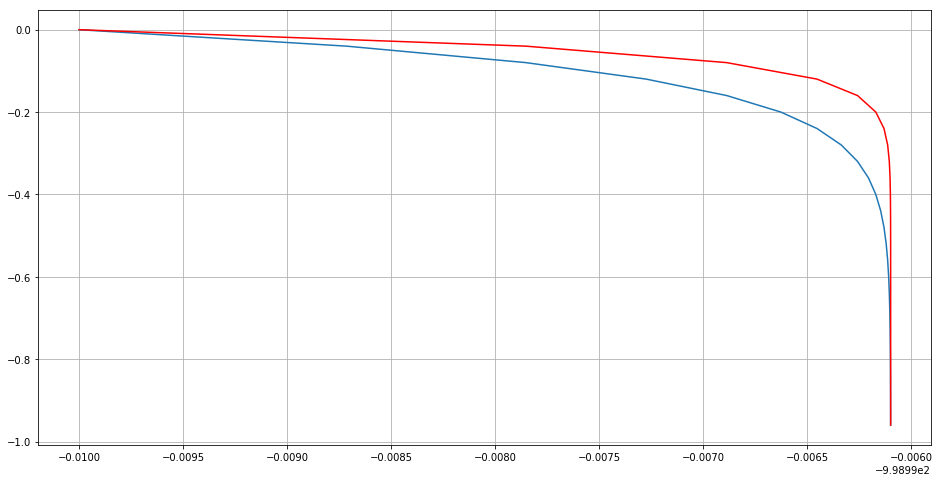

3.162277660168379
4.47213595499958


In [190]:
# testing from Smith and Vallis 2001 
# side note (look at time/space correlations of spice along an isopycnal at different depths (structure functions?))

delta = 0.1 
delta2 = 0.05
# as delta gets smaller, stratification intensifies at the surface 
H = 5000
ddd = (1028 - 1024)/(1025)
zz = np.arange(0, -5000, -200)
zbar = zz / H 
rho = 1 + ddd * (1 - np.exp(zbar/delta))
rho2 = 1 + ddd * (1 - np.exp(zbar/delta2))

f, ax = plt.subplots()
ax.plot(rho - 1000, zbar)
ax.plot(rho2 - 1000, zbar, color='r')
plot_pro(ax)

print(delta**(-1/2))
print(delta2**(-1/2))
# as stratification intensifies near the surface (delta gets smaller), the coefficient in front of the triple 
# interaction coefficient increases in magnitude. This means the nonlinear interactions across modes are enhanced.
# does this mean energy more easily trasnfers across these modes (in which direction?)...towards the first baroclinic
# mode it seems (towards barotropization). This applies for all interactions that do NOT include the barotropic mode 
# as one in the triad. 